## Imports

In [10]:

import numpy as np
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D

import time
from numba import njit
from pyccel.epyccel import epyccel
from pyccel.decorators import types


## Pure python function

In [2]:
def solve_2d_linearconv_pure(u, un, nt, dt, dx, dy, c):
   
    row, col = u.shape

    for n in range(nt + 1): #boucle temps
        for j in range(row): #boucler ligne 
            for i in range(col): #chaque lement de la ligne on va boucler sur les colonnes
                un[j][i] = u[j][i] 

        for j in range(1, row): # boucle pour affectation des valeurs
            for i in range(1, col):
                #la fonction discretisée
                u[j, i] = (un[j, i] - (c * dt / dx * (un[j, i] - un[j, i - 1])) -(c * dt / dy * (un[j, i] - un[j - 1, i])))
                #condition aux limites
                u[0, :] = 1
                u[-1, :] = 1
                u[:, 0] = 1
                u[:, -1] = 1               
    return 0

## Numba accelerator

In [3]:
@njit(fastmath=True)
def solve_2d_linearconv_numba(u, un, nt, dt, dx, dy, c):
   
    row, col = u.shape
    for n in range(nt + 1): 
        for j in range(row):
            for i in range(col):
                un[j][i] = u[j][i] 

        for j in range(1, row):
            for i in range(1, col):
                u[j, i] = (un[j, i] - (c * dt / dx * (un[j, i] - un[j, i - 1])) -(c * dt / dy * (un[j, i] - un[j - 1, i]))) 
                u[0, :] = 1
                u[-1, :] = 1
                u[:, 0] = 1
                u[:, -1] = 1 
    return 0

## Pyccel accelerator

In [20]:
@types('float[:,:]','float[:,:]', 'int', 'float','float', 'float' , 'int') # declaration des types des variables
def solve_2d_linearconv_pyccel(u, un, nt, dt, dx, dy, c): 
    row, col = u.shape

    for n in range(nt + 1): 
        for j in range(row):
            for i in range(col):
                un[j][i] = u[j][i] 
        
        for j in range(1, row):
            for i in range(1, col):
                u[j, i] = (un[j, i] - (c * dt / dx * (un[j, i] - un[j, i - 1])) -(c * dt / dy * (un[j, i] - un[j - 1, i]))) 
                u[0, :] = 1
                u[-1, :] = 1
                u[:, 0] = 1
                u[:, -1] = 1 
    return 0

## Inputs

/tmp/ipykernel_10946/3949030071.py:22: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')
/tmp/ipykernel_10946/3949030071.py:27: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


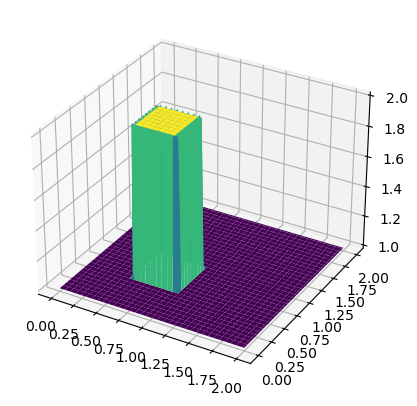

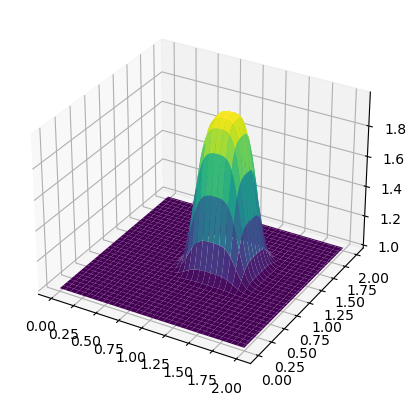

In [5]:
###variable declarations
nx = 101
ny = 101
nt = 100
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
sigma = .2
dt = sigma * dx

x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)

u0 = np.ones((ny, nx)) ##create a 1xn vector of 1's
u0[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2 
u = u0.copy()
un = np.ones((ny, nx)) 

solve_2d_linearconv_pure(u, un, nt, dt, dx, dy, c)

fig = pyplot.figure(figsize=(7, 5), dpi=100)
ax = fig.gca(projection='3d')                      
X, Y = np.meshgrid(x, y)                            
surf = ax.plot_surface(X, Y, u0[:], cmap=cm.viridis)

fig = pyplot.figure(figsize=(7, 5), dpi=100)
ax = fig.gca(projection='3d')
surf2 = ax.plot_surface(X, Y, u[:], cmap=cm.viridis)

## Call Funtions

### Pure function

In [7]:
%timeit solve_2d_linearconv_pure(u, un, nt, dt, dx, dy, c)

8.16 s ± 100 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Function with numba accelerator

In [8]:
%timeit solve_2d_linearconv_numba(u, un, nt, dt, dx, dy, c)

71 ms ± 406 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Function with pyccel accelerator

In [21]:
solve_2d_linearconv_f90 = epyccel(solve_2d_linearconv_pyccel)

In [22]:
%timeit solve_2d_linearconv_f90(u, un, nt, dt, dx, dy, c)

108 ms ± 2.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


    Nous constatons que l'optimisation d'acceleration du systeme de calcul a base numba et pyccel accelator sont plus performentes dans les equation de type lineaire, c'est complement logique qu'on aura pas les meme performance et diffenrence de temps de compilation entre les fonctions de pytho par defaut et les fonction des accelerations puisque nous somme dans la deuxieme dimension qui necessite plus de calcul en parallele.
    En outre on peut constater que numba est plus perfomrante au contraire du cas du 1D.